In [228]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
idx = pd.IndexSlice

In [229]:
with open('data/usage', 'rb') as file:
    usage = pickle.load(file)
usage

,Usage
Extra Soft,0.010165
Soft,0.010271
Medium,0.006243
Hard,0.005913
Rain,0.005172
Fuel,0.003864


In [230]:
tracks = pd.read_pickle('data/96/tracks')
tracks.index += 1
tracks['Lap distance'] = pd.to_numeric(tracks['Lap distance'].str.split().str[0])
tracks

,Track name,Country,Kms,Laps,Lap distance,Power,Handling,Acceleration,Category,GPs held
1,Buenos Aires,Argentina,306.6,72,4.258,NaN,NaN,NaN,ex F1,35
2,Rafaela Oval,Argentina,317.3,67,4.736,NaN,NaN,NaN,non F1,15
3,Adelaide,Australia,298.6,79,3.780,NaN,NaN,NaN,ex F1,32
4,Melbourne,Australia,307.6,58,5.303,NaN,NaN,NaN,F1,33
5,A1-Ring,Austria,307.1,71,4.325,NaN,NaN,NaN,F1,25
...,...,...,...,...,...,...,...,...,...,...
60,Indianapolis,United States,306.6,73,4.200,NaN,NaN,NaN,ex F1,23
61,Indianapolis Oval,United States,804.4,200,4.022,NaN,NaN,NaN,non F1,14
62,Laguna Seca,United States,284.5,79,3.601,NaN,NaN,NaN,non F1,27
63,Las Vegas,United States,305.9,50,6.118,NaN,NaN,NaN,F1,1


In [231]:
practice = pd.read_pickle('data/quali_practice')
practice

1,Lap,Lap time,Driver mistake,Net time,FWing,RWing,Engine,Brakes,Gear,Susp,Tyres,Comm
2,1,1:07.833s,0.968s,1:06.865s,650,650,350,500,500,500,Extra Soft,NaN
3,2,1:07.449s,0.698s,1:06.751s,650,650,600,500,350,650,Extra Soft,NaN
4,3,1:07.380s,0.671s,1:06.709s,700,650,525,500,350,650,Extra Soft,NaN
5,4,1:06.920s,0.272s,1:06.648s,700,700,475,500,350,650,Extra Soft,NaN
6,5,1:08.536s,1.619s,1:06.917s,700,700,475,500,350,650,Soft,NaN
7,6,1:07.544s,0.357s,1:07.187s,700,700,475,500,350,650,Medium,NaN
8,7,1:09.068s,1.612s,1:07.456s,700,700,475,500,350,650,Hard,NaN
9,8,1:07.715s,1.067s,1:06.648s,700,700,475,500,350,650,Extra Soft,NaN


In [232]:
pitstime = pd.read_pickle('data/pitstime')
pitstime

,N,Average
No more fuel was left,9,25.259111
Tyres change due to the weather change,4,31.196


In [233]:
tyres = ['Extra Soft', 'Soft', 'Medium', 'Hard', 'Rain']
strategies = pd.DataFrame([], tyres, ['Stints', 'Stops', 'Time'])

Convert net time to seconds

In [234]:
from datetime import datetime, timedelta

In [235]:
def to_timedelta(str, format = '%M:%S.%fs'):
    parsed_time = datetime.strptime(str, format)
    return timedelta(
        minutes=parsed_time.minute,
        seconds=parsed_time.second,
        microseconds=parsed_time.microsecond
    )

In [236]:
practice['Net time'] = practice['Net time'].apply(lambda t: to_timedelta(t).total_seconds())
practice

1,Lap,Lap time,Driver mistake,Net time,FWing,RWing,Engine,Brakes,Gear,Susp,Tyres,Comm
2,1,1:07.833s,0.968s,66.865,650,650,350,500,500,500,Extra Soft,NaN
3,2,1:07.449s,0.698s,66.751,650,650,600,500,350,650,Extra Soft,NaN
4,3,1:07.380s,0.671s,66.709,700,650,525,500,350,650,Extra Soft,NaN
5,4,1:06.920s,0.272s,66.648,700,700,475,500,350,650,Extra Soft,NaN
6,5,1:08.536s,1.619s,66.917,700,700,475,500,350,650,Soft,NaN
7,6,1:07.544s,0.357s,67.187,700,700,475,500,350,650,Medium,NaN
8,7,1:09.068s,1.612s,67.456,700,700,475,500,350,650,Hard,NaN
9,8,1:07.715s,1.067s,66.648,700,700,475,500,350,650,Extra Soft,NaN


Calculate strategy times per tyre

In [237]:
def get_strategies(track, min_tyre):
    usage['Laps'] = 1 / (min_tyre*usage['Usage']*tracks.loc[track, 'Lap distance'])
    strategies['Stints'] = tracks.loc[track, 'Laps'] / np.floor(usage['Laps'])
    strategies['Stops'] = np.ceil(strategies['Stints']) - 1 # np.ceil(x) - 1 != np.floor(x) e.g. x = 1
    strategies['Time'] = practice.groupby('Tyres')['Net time'].min() * tracks.loc[track, 'Laps']+ pitstime.loc['No more fuel was left', 'Average'] * strategies['Stops']
    return strategies

Text(0, 0.5, 'Total racetime')

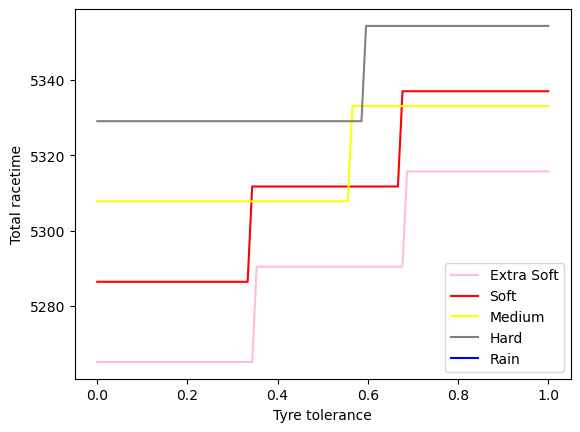

In [242]:
col = {'Extra Soft': 'pink', 'Soft': 'red', 'Medium': 'yellow', 'Hard': 'grey', 'Rain': 'blue'}
grid = np.linspace(0.0001, 1, 100)
times = pd.DataFrame([get_strategies(62, x)['Time'] for x in grid])
for tyre in times:
    plt.plot(grid, times[tyre], c = col[tyre], label = tyre)
plt.legend()
plt.xlabel('Tyre tolerance')
plt.ylabel('Total racetime')

In [239]:
get_strategies(14, 1).loc['Extra Soft', 'Time']

3808.065333333333

In [240]:
get_strategies(13, 0.1)

,Stints,Stops,Time
Extra Soft,0.310811,0,4598.712
Soft,0.313636,0,4617.273
Medium,0.190608,0,4635.903
Hard,0.180628,0,4654.464
Rain,0.157895,0,NaN
